In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate

import scipy.ndimage
import re
# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

tidy3dAPI = os.environ["API_TIDY3D_KEY"]


In [2]:
field_folder = r"./data/20251006_far_field_eps_8p57_ff_21p72_air.h5"

In [3]:
field_ref = AM.read_hdf5_as_dict("./data/20251023_Balistic_Transmission/20251006_Ref_air_complete_field.h5")
# field = AM.read_hdf5_as_dict("./data/20251023_Balistic_Transmission/20251006_far_field_eps_8p570256250000002_ff_21p72_air_complete_field.h5")
field = AM.read_hdf5_as_dict(field_folder)

In [4]:
#Open experimental data 
with open(r"H:\phd stuff\tidy3d\Notebooks\LSU Project\20250410 Sphere Discretization LSU\data\20251023_Balistic_Transmission\wavelenght_2_8_mu.txt", 'rb') as file:
        content = file.read()

        
# Decode the binary content to a string
decoded_content = content.decode('utf-8')

# Split the content into lines
lines = decoded_content.split('\r\n')
# Initialize an empty list to store the parsed values
lambdas_experiment= []

# Loop through each line and split by the comma
for line in lines:
    if line:  # Skip any empty lines
        value1 = line.split(',')[0]
        lambdas_experiment.append(float(value1))  # Convert values to float

In [5]:
def solid_angle_weights(theta):
    # theta: 1D array of polar angles (radians), length nθ
    # assume phi grid uniform; we compute Δθ and Δφ from vectors
    ntheta = theta.size
    # if theta input is cell centers, use diffs; else approximate
    dtheta = np.empty(ntheta)
    dtheta[1:-1] = 0.5*(theta[2:]-theta[1:-1]) + 0.5*(theta[1:-1]-theta[:-2])
    dtheta[0] = theta[1]-theta[0]
    dtheta[-1] = theta[-1]-theta[-2]
    return np.sin(theta) * dtheta  # returns length ntheta, ΔΩ = sinθ Δθ Δφ (φ part multiplies later)

def compute_transmission(
    E_theta_ref, E_phi_ref,   # shape (n_freq, n_theta, n_phi) complex (use None if missing)
    E_theta_scat, E_phi_scat, # same shapes for scatterer
    theta, phi                 # 1D arrays in radians
):
    # phi spacing (assume uniform)
    theta_mask = np.where(np.bool_(theta*180/np.pi >=15) & np.bool_(theta*180/np.pi <=30))[0]

    dphi=np.diff(phi)[1]
    w_theta = solid_angle_weights(theta[theta_mask])   # shape (n_theta,)
    # make 2D weight grid ΔΩ_ij = sinθ * Δθ * Δφ
    W = np.outer(w_theta, np.ones_like(phi)) * dphi  # shape (n_theta, n_phi)
    nfreq = E_theta_ref.shape[-1] if E_theta_ref is not None else E_phi_ref.shape[-1]
    T_ballistic = np.zeros(nfreq, dtype=float)
    T_co = np.zeros(nfreq, dtype=float)
    T_cross = np.zeros(nfreq, dtype=float)


    for k in range(nfreq):

        Eref = np.stack([E_theta_ref[theta_mask,:,k], E_phi_ref[theta_mask,:,k]], axis=-1)   # (nt,np,2)
        Escat = np.stack([E_theta_scat[theta_mask,:,k], E_phi_scat[theta_mask,:,k]], axis=-1)

        # |E_ref|^2
        P_ref = np.sum(Eref * np.conj(Eref), axis=-1).real   # (nt,np)

        # dot products
        dot_scat_ref = np.sum(Escat * np.conj(Eref), axis=-1)    # numerator of projection

        mask = P_ref > 0
        sqrtPref = np.zeros_like(P_ref)
        sqrtPref[mask] = np.sqrt(P_ref[mask])

        # co-polarized field (safe)
        E_co = np.zeros_like(dot_scat_ref)
        E_co[mask] = dot_scat_ref[mask] / sqrtPref[mask]

        # co-polarized power
        P_co = np.abs(E_co)**2

        # total scattered power
        P_scat = np.sum(Escat * np.conj(Escat), axis=-1).real

        # cross-polarized definition
        P_cross = P_scat - P_co   # fine, because P_co=0 in masked regions
        

        # Integrate each over solid angle
        T_co[k]    = np.sum(P_co    * W) / np.sum(P_ref * W)
        T_cross[k] = np.sum(P_cross * W) / np.sum(P_ref * W)

        # Ballistic (your A factor)
        inner_num = np.sum(dot_scat_ref * W)
        inner_den = np.sum(P_ref * W)
        A = inner_num / inner_den
        T_ballistic[k] = np.abs(A)**2


    return T_ballistic, T_co, T_cross  # array over frequencies


In [6]:
components_data = {}
for field_item in field.keys():
    print(field_item)
    T_ballistic, T_co, T_cross = compute_transmission(field_ref["Etheta"].squeeze(),
                                                  field_ref["Ephi"].squeeze(),
                                                  field[field_item]["Etheta"].squeeze(),
                                                  field[field_item]["Ephi"].squeeze(),
                                                  field_ref["theta_proj"],
                                                  field_ref["phi_proj"])
    if field_item not in components_data.keys():
        components_data[field_item] = {}
    components_data[field_item]["T_ballistic"] = T_ballistic
    components_data[field_item]["T_co"] = T_co  
    components_data[field_item]["T_cross"] = T_cross

n_2.9275_ff_0.2172_size_0.34965034965034963
n_2.9275_ff_0.2172_size_0.6118881118881119
n_2.9275_ff_0.2172_size_0.6993006993006993
n_2.9275_ff_0.2172_size_0.7867132867132867
n_2.9275_ff_0.2172_size_0.8741258741258741


In [7]:
#Open experimental data 
with open(r"H:\phd stuff\tidy3d\Notebooks\LSU Project\20250410 Sphere Discretization LSU\data\20251023_Balistic_Transmission\h09p4_sample3_spot1.txt", 'rb') as file:
        content = file.read()

        
# Decode the binary content to a string
decoded_content = content.decode('utf-8')

# Split the content into lines
lines = decoded_content.split('\r\n')
# Initialize an empty list to store the parsed values
T_ballistic_experiment= []
T_co_experiment= []
T_cross_experiment= []

# Loop through each line and split by the comma
for line in lines:
    if line:  # Skip any empty lines
        value1 = line.split(',')[6] #ballistic
        value2 = line.split(',')[2] #copolarized
        value3 = line.split(',')[4] #cross
        T_ballistic_experiment.append(float(value1))  # Convert values to float
        T_co_experiment.append(float(value2))
        T_cross_experiment.append(float(value3))

In [8]:
# gap_edges = np.array([4.67666044, 4.53468   ])
gap_edges = 14.3*0.8/np.array([2.44619,2.52278])
gap_center = np.mean(gap_edges)
gap_center


4.605670217586479

C:\Users\HernandF\AppData\Local\Temp\ipykernel_42812\140760953.py:32: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plot_item.set_ylim(0,0.35)


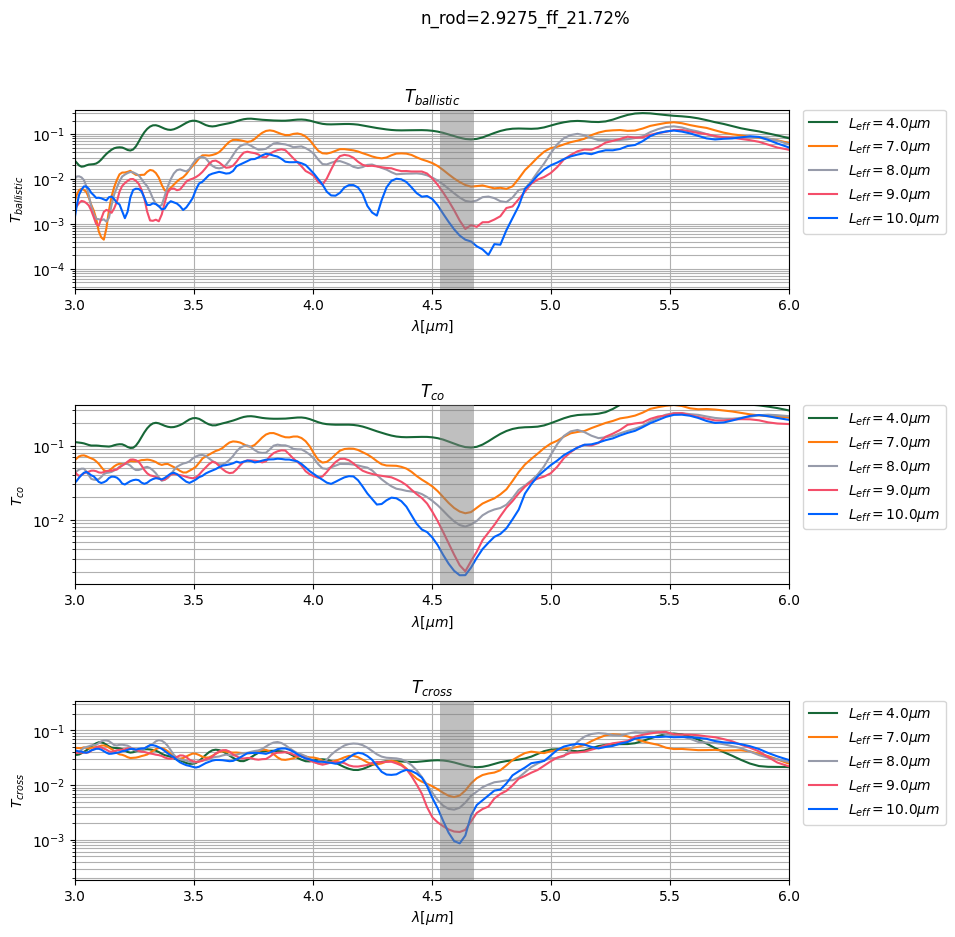

In [9]:
fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(12,10))
flatten_ax = ax.flatten()
titles = [r"$T_{ballistic}$", r"$T_{co}$", r"$T_{cross}$"]
window = 5
folder_save = rf"./data/20251216_Transmission_componenents_txt"
os.makedirs(folder_save,exist_ok=True)
for element in components_data.keys():
    size = float(re.search(r'size_([+-]?\d+(?:\.\d+)?)', element).group(1))*14.3*0.8
    lambda_smooth = AM.moving_average(td.C_0/field_ref["freqs"],window)
    
    #plot ballistic
    ballistic = AM.moving_average(components_data[element]["T_ballistic"],window)
    flatten_ax[0].plot(lambda_smooth,ballistic,label=rf"$L_{{eff}}={size}\mu m$")
    #plot T_co
    T_co = AM.moving_average(components_data[element]["T_co"],window)
    flatten_ax[1].plot(lambda_smooth,T_co,label=rf"$L_{{eff}}={size}\mu m$")
    #plot T_cross
    T_cross = AM.moving_average(components_data[element]["T_cross"],window)
    flatten_ax[2].plot(lambda_smooth,T_cross,label=rf"$L_{{eff}}={size}\mu m$")
    # plt.plot(lambdas_experiment,experiment_values[i],label=r"Experiment $L=9.4\mu m$")
    data_store = [lambda_smooth,ballistic,T_co,T_cross]
    flatten_ax[0].set_yscale('log')
    flatten_ax[1].set_yscale('log')
    flatten_ax[2].set_yscale('log')
    # np.savetxt(rf"{folder_save}/sim_n_rod_2p9275_ff_21p72_size_{size:.2f}_um.txt", np.transpose(data_store) , fmt="%.18f", delimiter=" ", header="lambda t_ballistic t_co t_cross", comments="")
flatten_ax[0].axvspan(gap_edges[0], gap_edges[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)
flatten_ax[1].axvspan(gap_edges[0], gap_edges[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)
flatten_ax[2].axvspan(gap_edges[0], gap_edges[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)

    
for i, plot_item in enumerate(flatten_ax):
    plot_item.set_ylim(0,0.35)
    plot_item.set_xlim(3,6)
    plot_item.grid(visible=True,which="both")
    plot_item.set_ylabel(rf"{titles[i]}")
    plot_item.set_xlabel(rf"$\lambda[\mu m]$")
    plot_item.set_title(titles[i])
    plot_item.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    
fig.subplots_adjust(right=0.72)
plt.suptitle(rf"n_rod=2.9275_ff_21.72%")
plt.subplots_adjust(hspace=0.65)
plt.savefig(rf"{folder_save}/transmission_components_n_rod_2p9275_ff_21p72.pdf",dpi=300)
plt.show()

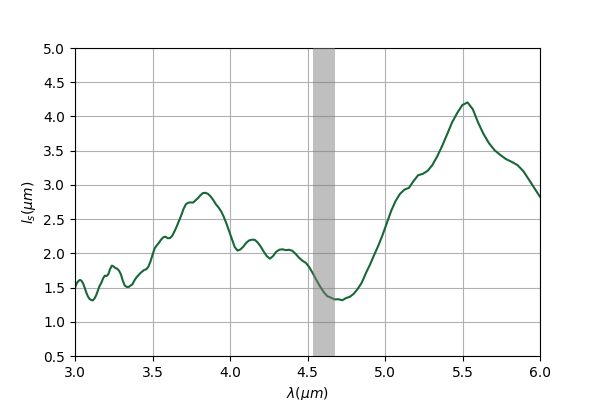

In [10]:
# Compute exponential decay length (ls) per wavelength by fitting

%matplotlib widget
window=6
lambda_smooth = AM.moving_average(td.C_0/field_ref["freqs"],window)

elements = list(components_data.keys())
# Extract sizes (L) in same order as components_data keys
sizes = np.array([float(re.search(r'size_([+-]?\d+(?:\.\d+)?)', el).group(1))*14.3*0.8 for el in elements])
# Ballistic data: shape (n_samples, n_freq)
ballistic_data = np.array([AM.moving_average(components_data[item]["T_ballistic"],window) for item in elements])
nfreq = ballistic_data.shape[1]

ls_array = np.full(nfreq, np.nan)
A_array = np.full(nfreq, np.nan)
from scipy.optimize import curve_fit
def exp_model(L, ls):
    return -L/ls


for k in range(nfreq):
    y = ballistic_data[:, k]
    x = sizes[:]
    p0 = [1]
    popt, pcov = curve_fit(exp_model, x, np.log(y), p0=p0, maxfev=5000)
    ls_array[k] = popt[0]
#     plt.plot(x, np.log(y), 'o', label='Data')
#     plt.plot(x, exp_model(x, *popt), '-', label='Fitted curve')
#     plt.show()

# raise Exception
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(lambda_smooth, ls_array)
ax.axvspan(gap_edges[0], gap_edges[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)
ax.set_xlabel(rF'$\lambda (\mu m)$')
ax.set_ylabel(rf'$l_s (\mu m)$')
ax.grid(True)
ax.set_xlim(3,6)
ax.set_ylim(0.5,5)
plt.show()

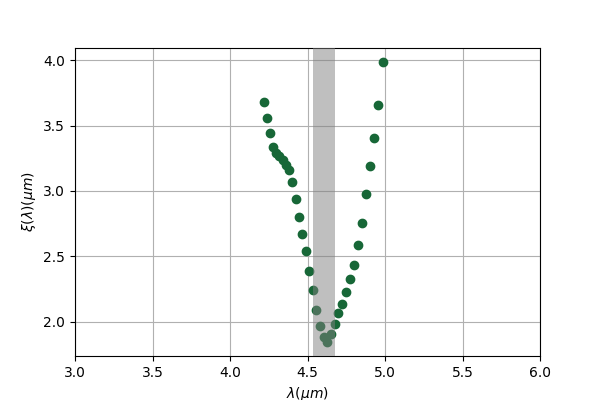

In [11]:
#Get the decay lengths at specific wavelengths
total_transmission = np.array([AM.moving_average(components_data[item]["T_ballistic"],window) for item in elements]) + \
                     np.array([AM.moving_average(components_data[item]["T_co"],window) for item in elements]) + \
                     np.array([AM.moving_average(components_data[item]["T_cross"],window) for item in elements]) 


def exp_model(L, xi):
    return -L/xi
xi_array = np.full(nfreq, np.nan)

for k in range(nfreq):
    if lambda_smooth[k] < 4.2 or lambda_smooth[k] > 5:
        continue
    y = total_transmission[:, k]
    x = sizes[:]
    p0 = [1]
    popt, pcov = curve_fit(exp_model, x, np.log(y), p0=p0, maxfev=5000)
    xi_array[k] = popt[0]

fig,ax = plt.subplots(figsize=(6,4))

ax.plot(lambda_smooth, xi_array,"o")
ax.axvspan(gap_edges[0], gap_edges[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)
ax.set_xlabel(rF'$\lambda (\mu m)$')
ax.set_ylabel(rf'$\xi(\lambda) (\mu m)$')
ax.grid(True)
ax.set_xlim(3,6)
# ax.set_ylim(0,5)
plt.show()
